In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from torchvision import transforms
from net import *
from utils import *
from loss import *
warnings.filterwarnings('ignore')

In [3]:
def error_analysis(chunk_size):
    
    ## parameters
    img_root = "D:/nyc_taxi/data_min_max"
    mask_root = "D:/nyc_taxi/data_min_max"
    image_size = 64
    batch_size = 24
    test_imgs = np.load(img_root+'/test.npy')
    test_masks_random = np.load(mask_root+'/test_random_mask.npy')
    dataset_test = taxi_data(test_imgs, test_masks_random, image_size, chunk_size)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    ## load models
    model_l1 = PConvUNet(chunk_size=chunk_size).to(device)
    model_l1.load_state_dict(torch.load(f'model_states/biased_l1_{chunk_size}'))
    
    ## spatial error
    gt_total = torch.zeros((64,64))
    l1_spatial_error = torch.zeros((64,64))
    l1_sequential_error = []
    all_time_max = 1428
        
    for i in range(24, len(dataset_test), batch_size):
        ## get data
        indices = range(i, min(len(dataset_test), i+batch_size))
        mask, gt = zip(*[dataset_test[j] for j in indices])
        mask = torch.stack(mask).to(device)
        gt = torch.stack(gt).to(device)
        image = mask*gt
        
        ## modeling
        with torch.no_grad():
            output_l1, _ = model_l1(gt, mask)
        output_comp_l1 = mask * gt + (1 - mask) * output_l1
        
        ## scale back
        gt = (gt*all_time_max).cpu()
        output_comp_l1 = (output_comp_l1*all_time_max).cpu()
        
        ## compute errors on the last image
        gt = gt[:,0,-1,:,:]
        output_comp_l1 = output_comp_l1[:,0,-1,:,:]
        
        ## spatial error
        l1_spatial_error += torch.sum(output_comp_l1-gt, dim=0)
        
        ## sequential error
        l1_sequential_error += ((torch.sum(torch.sum(output_comp_l1-gt, dim=1),dim=1).numpy()/64).tolist())
        
    ## spatial error
    n = (len(dataset_test)-24)
    l1_spatial_error = l1_spatial_error/n
    
    ## 24-hour period
    l1_sequential_error_24period = np.zeros(24)
    for i in range(int(n/24)):
        l1_sequential_error_24period += np.array(l1_sequential_error[i*24:(i+1)*24])
    l1_sequential_error_24period = l1_sequential_error_24period/int(n/24)

    ## plots
    plt.figure(figsize=(8,5))
    plt.title(f'Temporal Error Distribution, T={chunk_size}', size=18,y=1.05)
    plt.scatter(np.array(range(24)), l1_sequential_error_24period)
    plt.plot(l1_sequential_error_24period)
    plt.hlines(xmin=0,xmax=24,y=0,color='red')
    plt.xlabel('Hour of the Day', fontsize=16)
    plt.ylabel('Avg. L1 Error (Hole)', fontsize=16)
    plt.yticks(size=14)
    plt.yticks(size=14)

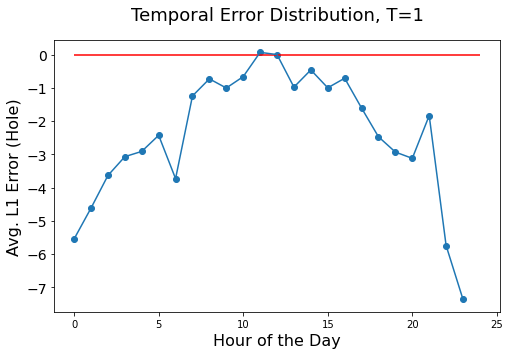

In [4]:
error_analysis(1)

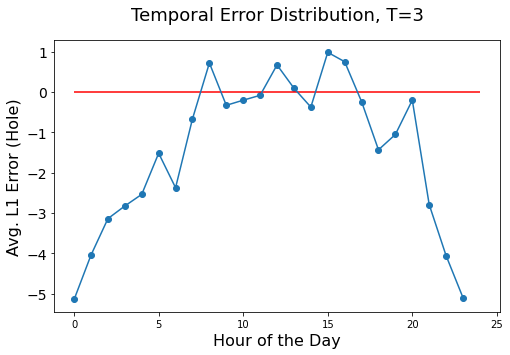

In [5]:
error_analysis(3)

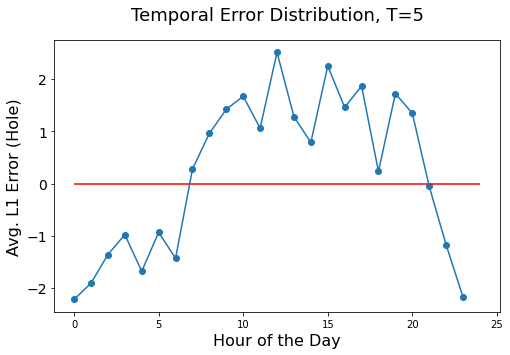

In [6]:
error_analysis(5)

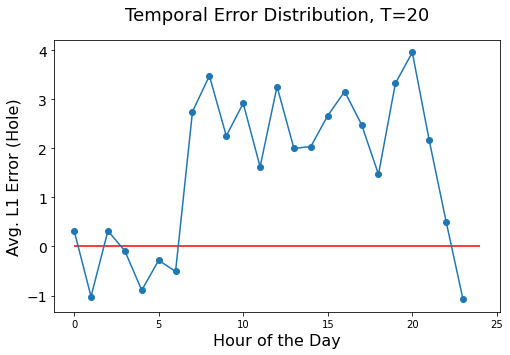

In [7]:
error_analysis(20)